# StreamingHistory0 Exploration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re

from datetime import datetime
from operator import itemgetter
from pprint import pprint
from itertools import combinations

In [2]:
with open("data/StreamingHistory0.json", mode="r", encoding="utf-8") as f:
    data = json.loads(f.read())

_df = pd.DataFrame(data)
_df.endTime = pd.to_datetime(_df.endTime)
skipped = _df[_df.msPlayed <= 10_000]
df = _df[_df.msPlayed > 10_000]
# df.endTime = df.endTime.apply(lambda dt: datetime.strptime(dt, "%Y-%m-%d %H:%M"))

In [3]:
# _df.groupby("trackName").apply(lambda df: (np.sum(df.msPlayed <= 10_000) / len(df), len(df))).sort_values(ascending=False).head(20)
# _df.sort_values(by="endTime", ascending=False).head(40)
_df[_df.endTime.dt.year == 2021].drop_duplicates().shape

(6539, 4)

Fleet Foxes      277
Fleetwood Mac    147
Name: artistName, dtype: int64
On the Floor    21
Honeybody       15
Name: trackName, dtype: int64


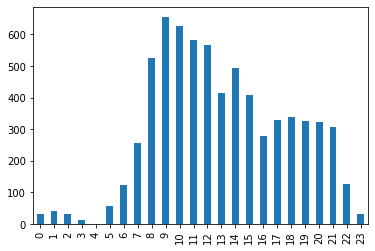

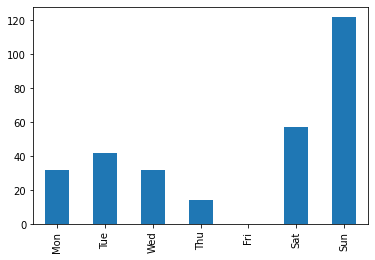

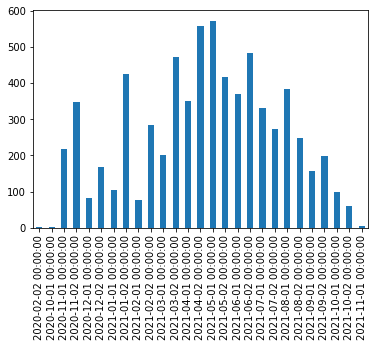

2020-01-07     1
2020-09-21     1
2020-09-29    17
2020-10-05    77
2020-10-06    51
              ..
2021-08-24    96
2021-09-20    70
2021-09-21    10
2021-09-27    33
2021-09-28    49
Name: endTime, Length: 97, dtype: int64

In [4]:
print(df.artistName.value_counts().head(2))
print(df.trackName.value_counts().head(2))
df[["artistName", "trackName"]].value_counts().head(5)

times = df.endTime.dt.hour.value_counts()
times = times.reindex(range(24), fill_value=0)
times.sort_index().plot(kind="bar")
plt.show()

weekdays = df.endTime.dt.dayofweek.value_counts()
weekdays = times.reindex(range(7), fill_value=0).sort_index()
weekdays.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
weekdays.plot(kind="bar")
plt.show()

months = df['endTime'] - pd.offsets.MonthBegin(0)
months = months.dt.round('d')
months = months.value_counts()
months = months.sort_index()
months.plot(kind="bar")
plt.show()

# Below is not correct
weeks = df['endTime'] - pd.to_timedelta(df['endTime'].dt.dayofweek, unit='d')
weeks = weeks.dt.round('d')
weeks = weeks.value_counts()
weeks = weeks.sort_index()
weeks


In [5]:
import requests

oauth_token = "Bearer BQAbeiv-i2bwyloeoj6gWNcNy2ca9XqvyuX5hi-GNrSJrEV4UFWK5M9z-ypghlM0_qPRwi6AfFhWMlDyIUnE_6oRnWpYefHNyBprpxqtURpvWvvyoUDp2vMJuQG7kF7nRNgCQ-F4Mkk27q9s_NRXyQhGF_1bPaYcRGU-uCjesV_Zp3U0Ill-40BSBjNirWQVUbGWvHV6FElCgNUEO98SCD9GlSmHblQ6xFS0rFAYr4KSgsMurWy3CCfMAbZ4T6YabqwAlRn_sxJfRPneMAI"
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "Authorization": oauth_token
}

def get_track_data_by_name(artist_name, track_name):
    def normalize_str(s):
        return re.sub("\'`´", "", s.lower())
    
    def search(params):
        resp = requests.get(endpoint, headers=headers, params=params)
        data = json.loads(resp.text)
        tracks = data['tracks']['items']
        found_tracks.update(", ".join(a["name"] for a in track["artists"]) + " - " + track["name"]
                            for track in tracks)
        return next(track for track in tracks
                       if normalize_str(track['name']) == normalize_str(track_name)
                       and artist_name in [a["name"] for a in track["artists"]])
    
    found_tracks = set()
    endpoint = "https://api.spotify.com/v1/search"
    params = {"q": track_name + " " + artist_name, "type": "track", "limit": 20}
    try:
        try:
            return search(params)
        except StopIteration:
            return search(params | {"q": track_name})
    except json.JSONDecodeError as e:
        print(resp.text)
        raise e
    except KeyError as e:
        print("bad data:")
        pprint(data)
        raise e
    except StopIteration:        
        print(f"unable to find: {artist_name} - {track_name}")
        print("found:", found_tracks, end="\n\n")
    

def get_artist_data_by_name(artist_name):
    endpoint = "https://api.spotify.com/v1/search"
    params = {"q": artist_name, "type": "artist", "limit": 10}
    resp = requests.get(endpoint, headers=headers, params=params)
    data = json.loads(resp.text)
    artist_data = [artist for artist in data['artists']['items'] if artist['name'] == artist_name]
    ranked_by_popularity = sorted(artist_data, key=lambda a: a['followers']['total'], reverse=True)
    
    if artist_data:
        return ranked_by_popularity[0]
    
    print("unable to find", artist_name)

def get_related_artists(artist_id):
    endpoint = f"https://api.spotify.com/v1/artists/{artist_id}/related-artists"
    resp = requests.get(endpoint, headers=headers)
    
    if resp.status_code == 200:
        return json.loads(resp.text)['artists']
    
    print("Could not find", artist_id)
    
#get_artist_data_by_name("Muse")

In [6]:
from ast import literal_eval

def scrape_track_data():
    # Uniquely identify tracks by artist_name + track_name
    # Since these are stored as a tuple, and json doesn't support tuple keys, extra work has to be done when reading and writing.
    # Spotify has unique ids for all tracks, but our local data doesn't. TODO: Integrate track and artist id into streaming history
    try:
        with open('data/track_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
            data = {literal_eval(k): v for k, v in data.items()}
    except FileNotFoundError:
        data = {}
        
    known_tracks = pd.Series(data.keys())
    all_tracks = pd.Series(df[["artistName", "trackName"]].agg(tuple, axis=1).unique())
    unknown_tracks = all_tracks[~all_tracks.isin(known_tracks)]
    
    if False:  # retrieve missing entries from spotify API
        try:
            for artist, track in unknown_tracks:
                result = get_track_data_by_name(artist, track)
                if result:
                    data[(artist, track)] = result
        finally:
            with open('data/track_data.json', mode='w+', encoding='utf-8') as f:
                json.dump({str(k): v for k,v in data.items()}, f)

    return data

def scrape_artist_data():
    try:
        with open('data/artist_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = []
        
    known_artists = pd.Series([artist['name'] for artist in data if artist is not None])
    all_artists = pd.Series(df.artistName.unique())
    unknown_artists = all_artists[~all_artists.isin(known_artists)]
    
    if False:  # retrieve missing entries from spotify API
        try:
            for artist in unknown_artists:
                result = get_artist_data_by_name(artist)
                if result:
                    data.append(result)
        finally:
            with open('data/artist_data.json', mode='w+', encoding='utf-8') as f:
                json.dump(data, f)

    return data


def scrape_related_artists(artist_ids):
    try:
        with open('data/related_artist_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = {}
    
    known_related = pd.Series(data.keys())
    missing_related = artist_ids[~artist_ids.isin(known_related)]
    
    if False:  # retrieve missing entries from spotify API
        try:
            for artist_id in missing_related:
                if (result := get_related_artists(artist_id)):
                    data[artist_id] = result
        finally:
            with open('data/related_artist_data.json', mode='w+', encoding='utf-8') as f:
                json.dump(data, f)

    return data

def read_audio_features(track_ids):
    try:
        with open('data/track_feature_data.json', mode='r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        data = {}
        
    return {k: v[0] for k, v in data.items()}


artist_data = pd.DataFrame(scrape_artist_data())
artist_data.columns = artist_data.columns.map(lambda s: "artist_" + s)

track_data = pd.DataFrame(scrape_track_data()).transpose()
track_data.columns = track_data.columns.map(lambda s: s if s.startswith("track_") else "track_" + s)

related_artists = pd.Series(scrape_related_artists(artist_data.artist_id), name="id")
track_features = pd.DataFrame(read_audio_features(track_data["track_id"])).transpose()

merged = pd.merge(_df, artist_data, left_on='artistName', right_on='artist_name', how='inner')

merged = pd.merge(merged, track_data, left_on=["artistName", "trackName"], right_index=True, how="left")

if False:
    keep_columns = list(df.columns) + ["artist_genres", "artist_id", "artist_popularity", "track_duration_ms", "track_id", "track_popularity"]
    write_df = merged[keep_columns]
    json_str = write_df.to_json(orient="records")
    with open("data/merged_history.json", mode="w+", encoding="utf-8") as f:
        f.write(json_str)


In [7]:
# track_features.key.value_counts()
track_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
3Be7CLdHZpyzsVijme39cW,0.75,0.664,8,-5.908,0,0.154,0.275,0,0.0632,0.617,105.023,audio_features,3Be7CLdHZpyzsVijme39cW,spotify:track:3Be7CLdHZpyzsVijme39cW,https://api.spotify.com/v1/tracks/3Be7CLdHZpyz...,https://api.spotify.com/v1/audio-analysis/3Be7...,208156,4
4MVJvkKhoeLPH3BcssmVpC,0.412,0.964,6,-7.557,0,0.169,0.000002,0.146,0.502,0.232,142.536,audio_features,4MVJvkKhoeLPH3BcssmVpC,spotify:track:4MVJvkKhoeLPH3BcssmVpC,https://api.spotify.com/v1/tracks/4MVJvkKhoeLP...,https://api.spotify.com/v1/audio-analysis/4MVJ...,293347,3
1Z3RQFrjlpxtD0vXuLRQJD,0.757,0.415,5,-3.827,1,0.0801,0.397,0.000492,0.0741,0.606,78.062,audio_features,1Z3RQFrjlpxtD0vXuLRQJD,spotify:track:1Z3RQFrjlpxtD0vXuLRQJD,https://api.spotify.com/v1/tracks/1Z3RQFrjlpxt...,https://api.spotify.com/v1/audio-analysis/1Z3R...,195773,4
4lyIHAc8sk6lm9iN5B8nmj,0.437,0.282,11,-17.437,0,0.0481,0.971,0.00105,0.115,0.156,143.927,audio_features,4lyIHAc8sk6lm9iN5B8nmj,spotify:track:4lyIHAc8sk6lm9iN5B8nmj,https://api.spotify.com/v1/tracks/4lyIHAc8sk6l...,https://api.spotify.com/v1/audio-analysis/4lyI...,221711,4
6ERZ30cRjVWGtVLhczX9aL,0.443,0.226,2,-12.507,0,0.0359,0.939,0.0201,0.14,0.196,79.142,audio_features,6ERZ30cRjVWGtVLhczX9aL,spotify:track:6ERZ30cRjVWGtVLhczX9aL,https://api.spotify.com/v1/tracks/6ERZ30cRjVWG...,https://api.spotify.com/v1/audio-analysis/6ERZ...,300361,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24AIahNHzBxm9S12peXbnG,0.281,0.212,6,-15.513,1,0.031,0.86,0.000077,0.119,0.195,95.555,audio_features,24AIahNHzBxm9S12peXbnG,spotify:track:24AIahNHzBxm9S12peXbnG,https://api.spotify.com/v1/tracks/24AIahNHzBxm...,https://api.spotify.com/v1/audio-analysis/24AI...,162893,3
4kEc9Bbxj7e4NwOWK5GU5x,0.694,0.711,0,-6.272,1,0.0255,0.000192,0.0303,0.362,0.606,110.016,audio_features,4kEc9Bbxj7e4NwOWK5GU5x,spotify:track:4kEc9Bbxj7e4NwOWK5GU5x,https://api.spotify.com/v1/tracks/4kEc9Bbxj7e4...,https://api.spotify.com/v1/audio-analysis/4kEc...,207187,4
0ru3CQZFLfX7EaAOWjNW9s,0.392,0.734,5,-7.17,1,0.0292,0.00684,0.24,0.329,0.673,141.93,audio_features,0ru3CQZFLfX7EaAOWjNW9s,spotify:track:0ru3CQZFLfX7EaAOWjNW9s,https://api.spotify.com/v1/tracks/0ru3CQZFLfX7...,https://api.spotify.com/v1/audio-analysis/0ru3...,286825,4
60944GSI60QrxJImNaYCP3,0.456,0.523,2,-8.738,1,0.0303,0.821,0.00231,0.11,0.35,133.063,audio_features,60944GSI60QrxJImNaYCP3,spotify:track:60944GSI60QrxJImNaYCP3,https://api.spotify.com/v1/tracks/60944GSI60Qr...,https://api.spotify.com/v1/audio-analysis/6094...,480200,4


In [8]:
def flatten_series(series):
    return series.apply(pd.Series).stack().reset_index(drop=True)

def genre_count(df):
    return flatten_series(df.genres).value_counts()

def weighted_genre_count(df):
    all_genres = flatten_series(df.genres).unique()
    
    genre_counts = {genre: 0 for genre in all_genres}
    for genres in df.genres:
        for g in genres:
            genre_counts[g] += 1/len(genres)

    genre_counts = {"genre": genre_counts.keys(), "popularity": genre_counts.values()}
    genre_count_df = pd.DataFrame(genre_counts).sort_values(by="popularity", ascending=False).reset_index(drop=True)
        
    return genre_count_df
    
    #exploded = df.genres.explode()
    #return (exploded.groupby(level=0).transform('count').groupby(exploded).sum()).sort_values(ascending=False)
    
    
def genre_adj_list(genre_lists):  # genre_lists is a nested list, each item being the genres of an artist
    genres = flatten_series(genre_lists).unique()
    num_genres = len(genres)
    adjacency_list = {g: [] for g in genres}
    for gs in genre_lists:
        for g in gs:
            adjacency_list[g] += gs
    
    for k, v in adjacency_list.items():
        adjacency_list[k] = [g for g in v if g != k]
        
    df = pd.DataFrame({"genre": adjacency_list.keys(), "neighbors": adjacency_list.values()})
    return df
    
    
def genre_adj_matrix(genre_lists):
    genres = flatten_series(genre_lists).unique()
    num_genres = len(genres)
    
    base_matrix = np.zeros((num_genres, num_genres))
    adj_matrix = pd.DataFrame(base_matrix, columns=genres, index=genres)
    
    
    for gs in genre_lists:
        for a, g in combinations(gs, 2):
            adj_matrix[a][g] += 1
            
    return adj_matrix
    
    
def co_occurrence_score(occurrences):
    # note: not correct
    adj_matrix = genre_adj_matrix(occurrences)
    flattened_genres = flatten_series(genres)
    total_occurrences = flattened_genres.groupby(flattened_genres).count()
    return adj_matrix.transpose() / total_occurrences
        

# genre_count(artist_data)
# weighted_genre_count(artist_data).head(20)

genres = artist_data.artist_genres
adj_matrix = genre_adj_matrix(genres)
adj_list = genre_adj_list(genres)

co_occs = co_occurrence_score(genres)
co_occs = co_occs[co_occs < 1]
co_occs = co_occs.stack()
co_occs.sort_values(ascending=False).head(20)

genre = genres[genres.apply(lambda l: "hard bop" in l)]
sum(genre.apply(lambda gs: "cool jazz" in gs)) / len(genre)


0.9705882352941176

# PCA Attempts

In [9]:
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

artist_id_series = pd.Series(0, index=artist_data.artist_id)

## PCA genres by artists

In [10]:
artist_genres = artist_data.artist_genres
genres = flatten_series(artist_genres).unique()

artist_names = artist_data.artist_name
genre_artist_vectors = np.array([
    np.array(artist_genres.apply(lambda gs: genre in gs))
    for genre in genres
])

print(genre_artist_vectors.shape)
pca = PCA(n_components=2)
transformed = pca.fit_transform(genre_artist_vectors)
# distances = pairwise_distances(genre_artist_vectors, metric="cosine")

(1049, 1516)


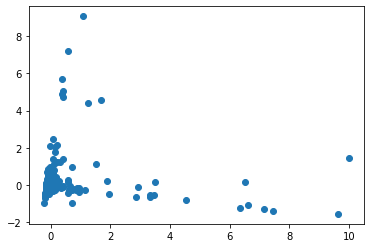

In [11]:
plt.scatter(*zip(*transformed))
plt.show()

## PCA artists by genres

In [12]:
artist_names = artist_data.artist_name
genres = pd.Series(flatten_series(artist_genres).unique())

artist_genre_vectors = np.array([
    np.array(genres.apply(lambda g: g in artists_genres))
    for artists_genres in artist_data.artist_genres
])

print(artist_genre_vectors.shape)
pca = PCA(n_components=2)
transformed = pca.fit_transform(artist_genre_vectors)

artist_genre_pca = artist_id_series.copy()
artist_genre_pca.loc[:] = list(map(tuple, transformed))

(1516, 1049)


In [13]:
np.mean(np.sum(artist_genre_vectors, axis=0))

6.593898951382269

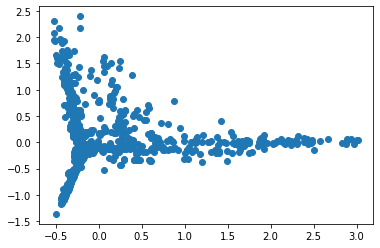

In [14]:
plt.scatter(*zip(*transformed))
plt.show()

## PCA artists by mean of track feature vectors

In [15]:
features = ["danceability", "valence", "speechiness", "acousticness", "instrumentalness", "liveness"]
wfeatures = pd.merge(merged, track_features, how="left", left_on="track_id", right_index=True)
for feat in features:
    wfeatures[feat] = wfeatures[feat].transform(float)

We may not have features for all tracks. If no track belonging to an artist has audio features, we have to drop that artist. 

In [16]:
wfeatures.artist_id.nunique()
missing_features_artist_ids = wfeatures[wfeatures.danceability.isna()]
print(missing_features_artist_ids.shape)
wfeatures = wfeatures[wfeatures.danceability.notna()]

(225, 49)


In [17]:
def compute_mean_artist_feature_vector(grouping):
    df = pd.DataFrame(grouping)
    return df[features].aggregate(np.mean, axis=0, raw=True).to_numpy()

mean_artist_features = wfeatures.groupby("artist_id").apply(compute_mean_artist_feature_vector)
artist_features_v = np.stack(mean_artist_features.values)

print(artist_features_v.shape)
pca = PCA(n_components=2)
transformed = pca.fit_transform(artist_features_v)

# We use the series to keep track of which artists maps to each feature vector / dr position
mean_artist_features.loc[:] = list(map(tuple, transformed))

(1508, 6)


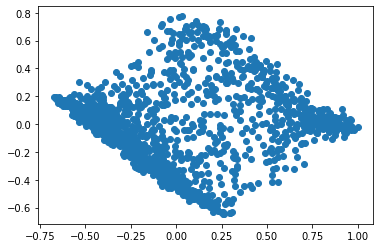

In [18]:
plt.scatter(*zip(*transformed))
plt.show()

## PCA artists by distribution of track feature vectors

In [19]:
from scipy.stats import norm
i = 0
def compute_norm_artist_feature_vector(grouping):
    def flatten(l):
        return [v for t in l for v in t]
    df = pd.DataFrame(grouping)
    # return [norm.fit(df[col])[0] for col in features]
    return flatten([norm.fit(df[col]) for col in features])
    # print(df[features].aggregate(norm.fit, axis=0, raw=True))

norm_artist_features = wfeatures.groupby("artist_id").apply(compute_norm_artist_feature_vector)
norm_artist_features_v = np.stack(norm_artist_features.values)

print(norm_artist_features_v.shape)
pca = PCA(n_components=2)
transformed = pca.fit_transform(norm_artist_features_v)

norm_artist_features.loc[:] = list(map(tuple, transformed))

(1508, 12)


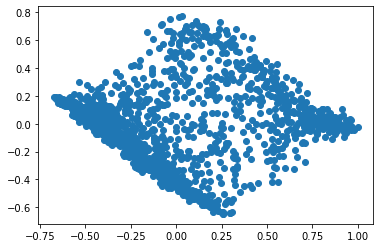

In [20]:
plt.scatter(*zip(*transformed))
plt.show()

## TSNE

In [21]:
from sklearn.manifold import TSNE

C:\Users\jonatan\code\vis_project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1508, 6)
(1508, 2)


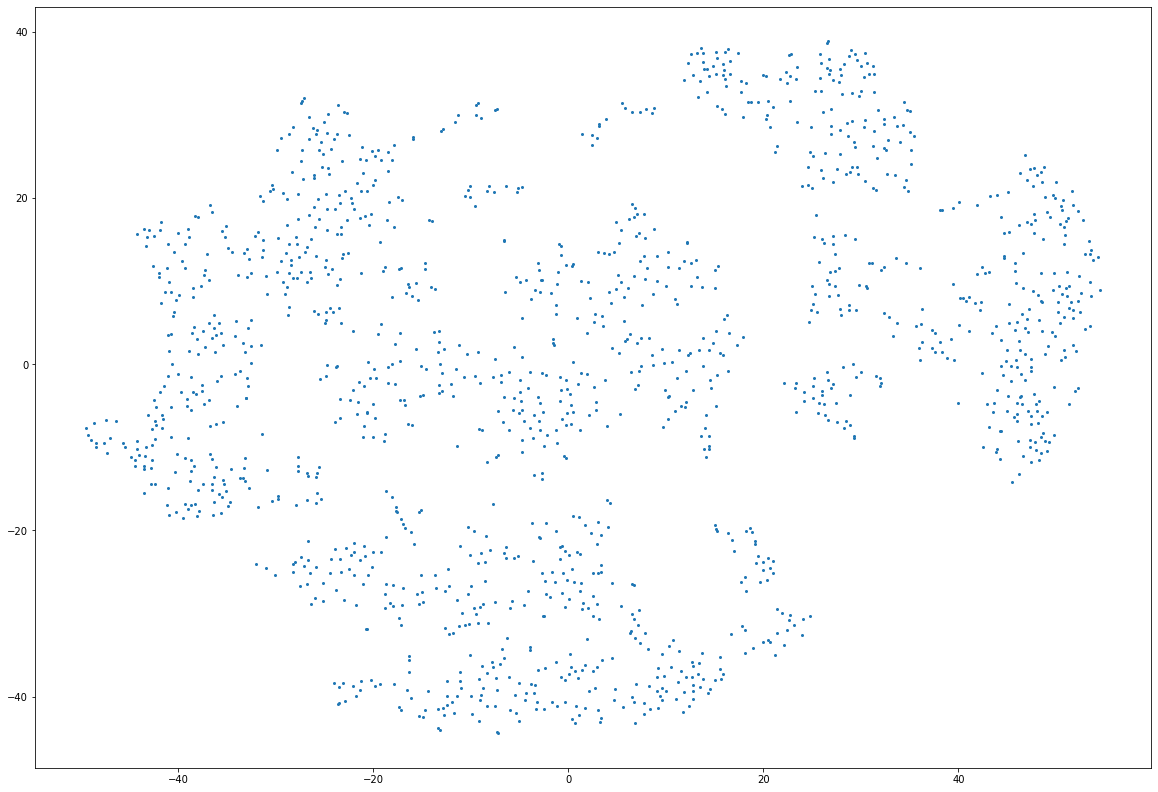

In [22]:
tf_embed = TSNE(
    n_components=2, learning_rate=300, init="pca" #, early_exaggeration=50
).fit_transform(norm_artist_features_v)

print(artist_features_v.shape)
print(tf_embed.shape)
plt.figure(figsize=(20, 14))
plt.scatter(*zip(*tf_embed), s=4)

tsne_artist_features = norm_artist_features.copy()
tsne_artist_features.loc[:] = list(map(tuple, tf_embed))

C:\Users\jonatan\code\vis_project\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1516, 2)


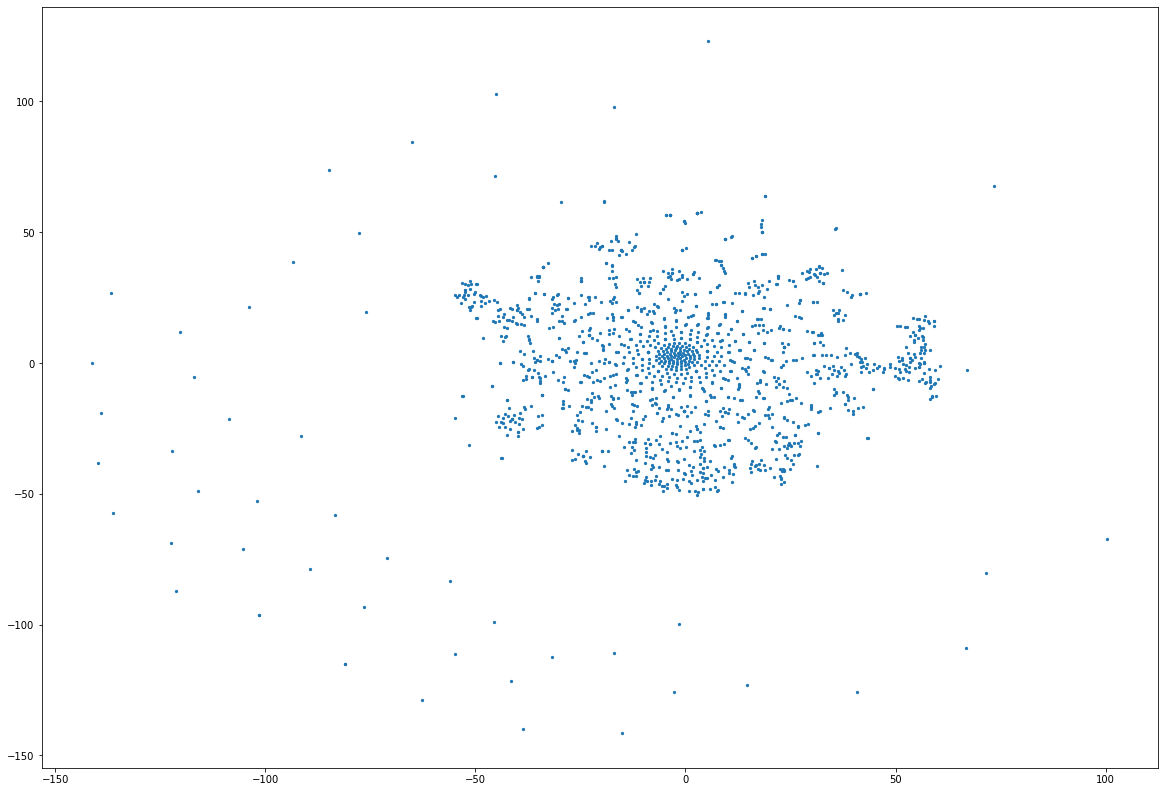

In [23]:
tf_embed_genre = TSNE(n_components=2, learning_rate=300, init="pca").fit_transform(artist_genre_vectors)

tsne_artist_genres = artist_id_series.copy()
tsne_artist_genres.loc[:] = list(map(tuple, tf_embed_genre))

print(tf_embed_genre.shape)
plt.figure(figsize=(20, 14))
plt.scatter(tf_embed_genre[:, 0], tf_embed_genre[:, 1], s=5)

In [24]:
tsne_artist_genres

artist_id
1zuJe6b1roixEKMOtyrEak      (35.867054, 19.00996)
457qPvtiBTIl6LR4dZiKZy        (9.290517, 17.6531)
5VF0YkVLeVD4ytyiyVSIiF    (-6.359009, -46.106743)
4MXUO7sVCaFgFjoTI5ox5c    (0.3444963, -28.148413)
00FQb4jTyendYWaN8pK0wa    (-9.535617, -30.510422)
                                   ...           
4br5HVmW3Xed5Zvffl0RSU     (18.288105, 50.255802)
5lhlKFCH9b5f5G43GgyJ2T     (-0.933641, 43.408276)
0z4ODfFM8PGE0A9r0tZ75J     (-9.894706, 21.205563)
2JC4hZm1egeJDEolLsMwZ9     (-6.699701, 21.681185)
09hVIj6vWgoCDtT03h8ZCa     (-21.08185, 45.940388)
Length: 1516, dtype: object

### TSNE Outlier Removal Using DBSCAN

(1516, 2)
(1435, 2)
(1516, 2)


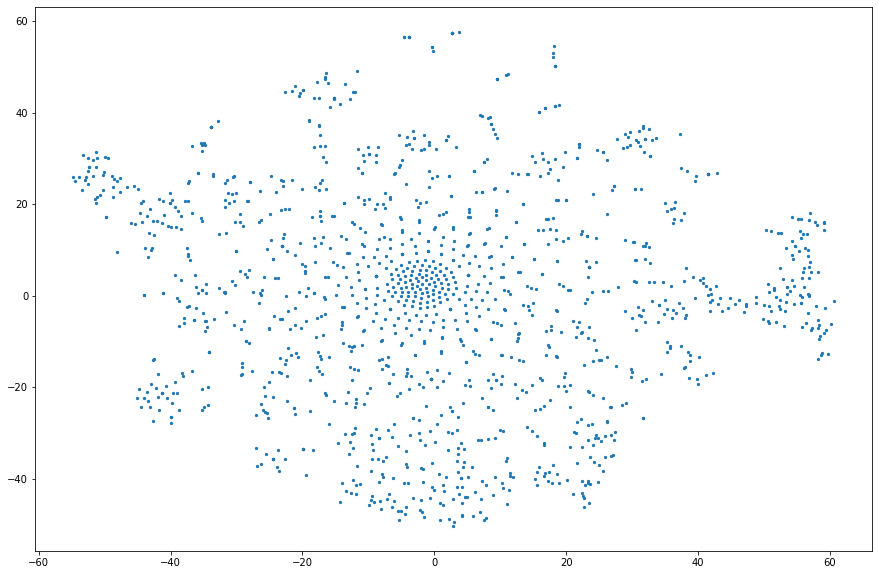

In [25]:
from sklearn.cluster import DBSCAN

genre_cluster = DBSCAN(eps=5).fit(tf_embed_genre)

genre_outliers_removed = tf_embed_genre[genre_cluster.labels_ != -1]
genre_outliers_nad = np.array(tf_embed_genre, copy=True)
genre_outliers_nad[genre_cluster.labels_ == -1] = np.nan

print(tf_embed_genre.shape)
print(genre_outliers_removed.shape)
print(genre_outliers_nad.shape)
 
plt.figure(figsize=(15, 10))
plt.scatter(*zip(*genre_outliers_removed), s=5)

tsne_artist_genres_no_outliers = artist_id_series.copy()
tsne_artist_genres_no_outliers.loc[:] = list(map(tuple, genre_outliers_nad))


(1508, 2)
(1508, 2)


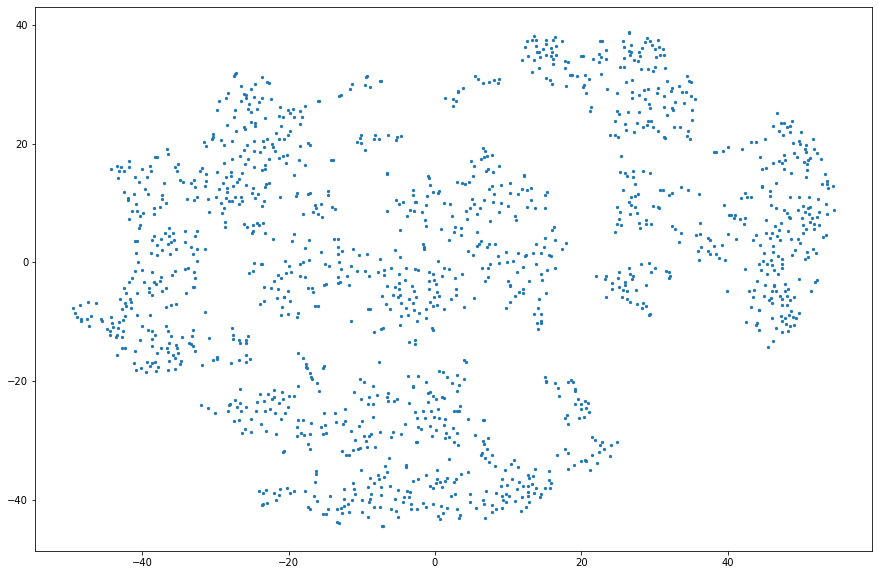

In [26]:
feature_cluster = DBSCAN(eps=5).fit(tf_embed)
feature_outliers_removed = tf_embed[feature_cluster.labels_ != -1]

feature_outliers_nad = np.array(tf_embed, copy=True)
feature_outliers_nad[feature_cluster.labels_ == -1] = np.nan

print(tf_embed.shape)
print(feature_outliers_removed.shape)

plt.figure(figsize=(15, 10))
plt.scatter(*zip(*feature_outliers_removed), s=5)

## Write to File

In [37]:
from math import isnan

dr_results = pd.DataFrame(artist_data.artist_id)

data = {
    "genre_pca": artist_genre_pca,
    "mean_feature_pca": mean_artist_features,
    "norm_feature_pca": norm_artist_features,
    "tsne_feature": tsne_artist_features,
    "tsne_genre": tsne_artist_genres,
    "tsne_genre_no_outliers": tsne_artist_genres_no_outliers
}

for col, series in data.items():
    dr_results = dr_results.merge(series.rename(col), how="left", left_on="artist_id", right_index=True)
    
# dr_results = dr_results.replace((np.nan, np.nan), np.nan)  # <-- This doesn't work due to nan != nan
for col in dr_results.columns:
    dr_results[col][dr_results[col].apply(lambda t: type(t) == tuple and any(map(isnan, t)))] = np.nan

dr_results = dr_results.fillna(np.nan).replace([np.nan], [None])


json_str = dr_results.to_json(orient="records")
with open("data/dr_results.json", mode="w+", encoding="utf-8") as f:
    f.write(json_str)
    pass


# END OF PCA

In [28]:
from dataclasses import dataclass, field
from typing import List, Type, Optional

@dataclass
class GenreNode:
    name: str
    split_name: List[str] = field(default_factory=list)
    parents: List[Type["GenreNode"]] = field(default_factory=list)
    children: List[Type["GenreNode"]] = field(default_factory=list)
    
    def __post_init__(self):
        self.split_name = self.name.replace("-", " ").split(" ")
    
    def __repr__(self):
        return f"{self.name}: ({len(self.children)}){[c.name for c in self.children]}" 
    
    def __len__(self):
        if not self.children: return 0
        return sum(len(child) or 1 for child in self.children)
    
    def is_supergenre_of(self, node):
        # second term is to prevent "dance pop" "pop dance" infinite loop
        return all(tok in node.split_name for tok in self.split_name) and len(self.split_name) < len(node.split_name)
    
    def remove_children_from_parents(self):       
        for parent in self.parents:
            for child in self.children:
                if child in parent.children:
                    parent.children.remove(child)
                if parent in child.parents:
                    child.parents.remove(parent)
            parent.remove_children_from_parents()
            
    def depth_from_parent(self, parent):
        if self == parent: return 0
        if not self.parents: return float("-inf")
        return max(map(lambda n: n.depth_from_parent(parent), self.parents)) + 1
            
    def print_tree(self, root=None, indent=0):
        print(indent*"\t" + f"{self.name} ({len(self)})")
        for child in sorted(self.children, key=lambda c: c.depth_from_parent(root), reverse=True):
            child.print_tree(root or self, indent+1)
            
    @staticmethod
    def tie_breaker(disputed_child, parents):
        # returns must suitable parent for child node. Returns None if unable to find best parent
        for i in range(len(disputed_child.split_name)):
            trimmed_child_name = " ".join(disputed_child.split_name[i:])
            matches = [parent for parent in parents
                       if " ".join(parent.split_name) == trimmed_child_name]  # Join split name instead of using name. Avoids issues with "-"
            if matches:
                if len(matches) == 1:
                    return matches[0]
                return None
            
            
def lexical_genre_hierarchy(genres): 
    def node_depth(node):
        if not node.parents: return 0
        return max(map(node_depth, node.parents)) + 1
    
    node_map = {genre: GenreNode(genre) for genre in genres}
    nodes = node_map.values()
    
    # first pass
    for node in nodes:
        subgenre_nodes = filter(node.is_supergenre_of, nodes)
        for subg_n in subgenre_nodes:
            if subg_n != node:
                node.children.append(subg_n)
                subg_n.parents.append(node)

    for leaf_node in filter(lambda n: n.parents and not n.children, nodes):
        leaf_node.remove_children_from_parents()
                 
    return node_map 


genre_series = pd.Series(flatten_series(genres).unique())
hierarchy = lexical_genre_hierarchy(genre_series)
ranked = sorted(hierarchy.values(), key=len, reverse=True)

for node in ranked[:3]:
    node.print_tree()                                              

for node in ranked[-3:]:
    node.print_tree()

rock (115)
	soft rock (1)
		deep soft rock (0)
	indie rock (6)
		indie garage rock (0)
		english indie rock (0)
		british indie rock (0)
		swedish indie rock (0)
		dutch indie rock (0)
		korean indie rock (0)
	alternative rock (8)
		norwegian alternative rock (0)
		modern alternative rock (0)
		alternative roots rock (0)
		swedish alternative rock (0)
		finnish alternative rock (0)
		japanese alternative rock (0)
		australian alternative rock (0)
		danish alternative rock (0)
	experimental rock (0)
	modern rock (4)
		modern blues rock (0)
		modern alternative rock (0)
		modern folk rock (0)
		modern hard rock (0)
	garage rock (4)
		indie garage rock (0)
		garage rock revival (0)
		canadian garage rock (0)
		japanese garage rock (0)
	progressive rock (1)
		italian progressive rock (0)
	symphonic rock (0)
	album rock (0)
	classic rock (4)
		mexican classic rock (0)
		classic canadian rock (0)
		classic j-rock (0)
		classic finnish rock (0)
	hard rock (2)
		swedish hard rock (0)
		modern 

In [29]:
top_genres = [n.name for n in ranked[:10]]
merged.genres = merged.artist_genres.apply(lambda gs: [g for g in gs if g in top_genres])

df.month = df.endTime - pd.offsets.MonthBegin(0)
df.month = df.month.dt.round('d')

C:\Users\jonatan\AppData\Local\Temp/ipykernel_6084/3342523293.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  merged.genres = merged.artist_genres.apply(lambda gs: [g for g in gs if g in top_genres])
C:\Users\jonatan\AppData\Local\Temp/ipykernel_6084/3342523293.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.month = df.endTime - pd.offsets.MonthBegin(0)


In [30]:
# pd.plotting.scatter_matrix(adj_matrix)
top = adj_matrix.idxmax().head(10)
[(gs, adj_matrix[gs[0]][gs[1]]) for gs in top.items()]
stacked = adj_matrix.stack()
stacked[stacked > 0].sort_values(ascending=False).head(20)

rock          classic rock    93.0
classic rock  album rock      76.0
mellow gold   classic rock    73.0
soft rock     mellow gold     72.0
rock          album rock      68.0
indie rock    indie pop       67.0
folk rock     classic rock    63.0
soft rock     classic rock    61.0
rock          mellow gold     60.0
mellow gold   folk rock       57.0
jazz          cool jazz       54.0
classic rock  art rock        53.0
art rock      album rock      52.0
mellow gold   album rock      52.0
soft rock     rock            51.0
rock          art rock        51.0
jazz fusion   jazz            50.0
soft rock     album rock      48.0
rock          folk rock       46.0
indie rock    freak folk      45.0
dtype: float64

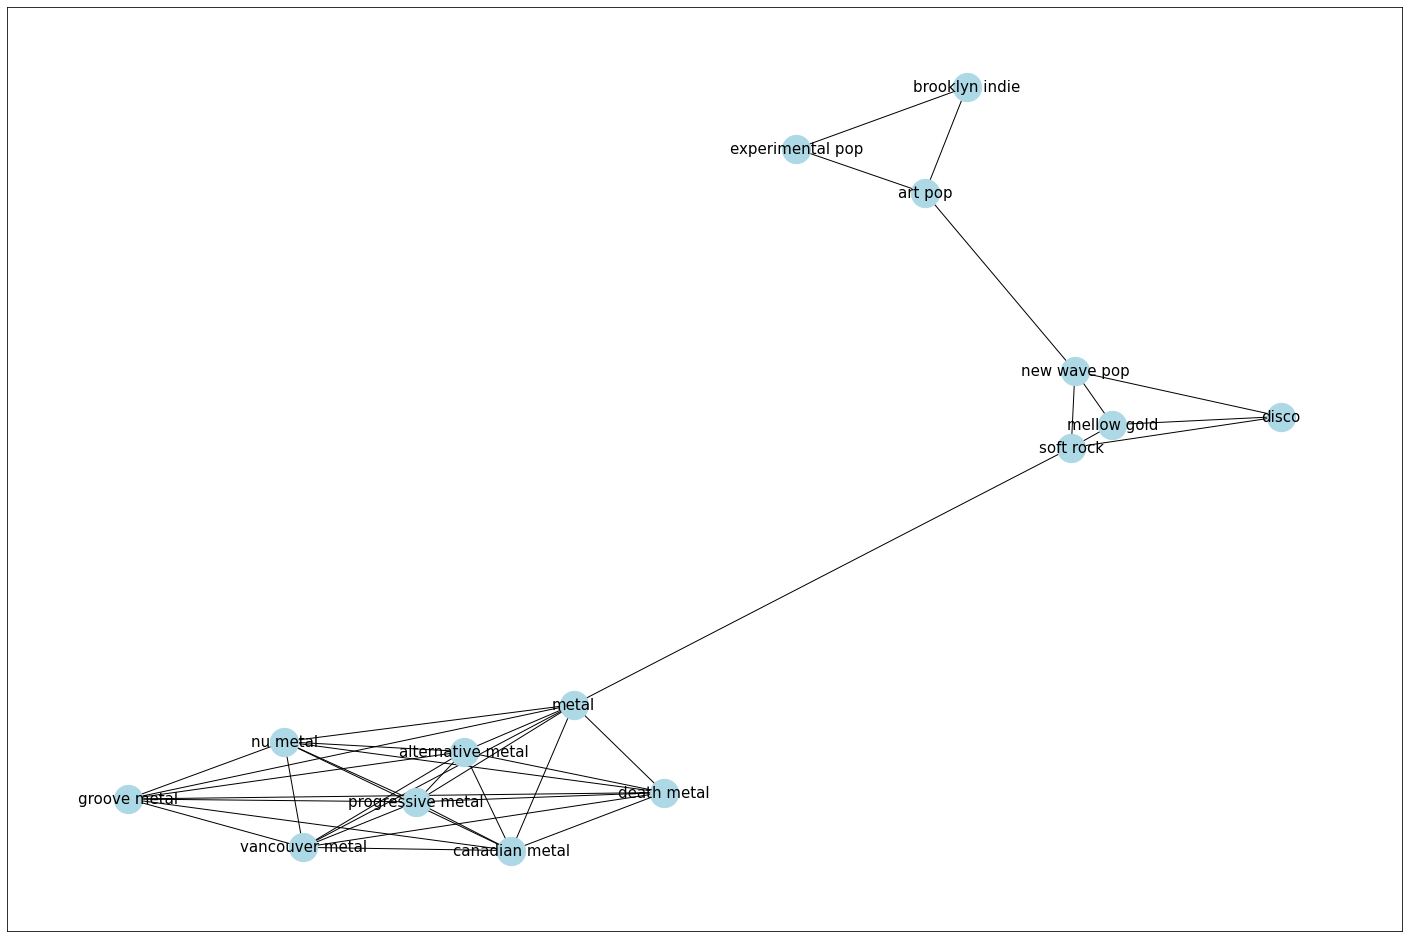

In [31]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, labels=adjacency_matrix.index, with_labels=True)
    plt.show()
    
# show_graph_with_labels(adj_matrix)
plt.figure(figsize=(25,17))
n = 15
nx.draw_networkx(nx.from_pandas_adjacency(adj_matrix[:n][:n]), node_size=800, node_color='lightblue', font_size=15)

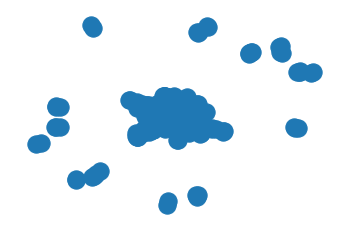

In [32]:
adj_list = genre_adj_list(artist_data.artist_genres)
G = nx.Graph()
for _idx, genre, neighbors in adj_list.itertuples():
    G.add_edges_from([(genre, n) for n in set(neighbors)])
    

pos = nx.spring_layout(G)    
nx.draw_networkx_edge_labels(G, pos)
nx.draw(G, pos, edge_color='black')
plt.show()

In [33]:
genre_count(merged).head(10)
merged.head(10)

weighted_genre_count(merged).head(10)

,genre,popularity
0,rock,1366.0
1,jazz,572.5
2,folk,513.5
3,hip hop,345.0
4,pop,240.5
5,metal,84.0
6,experimental,79.0
7,classical,63.0
8,punk,20.5
9,blues,12.0


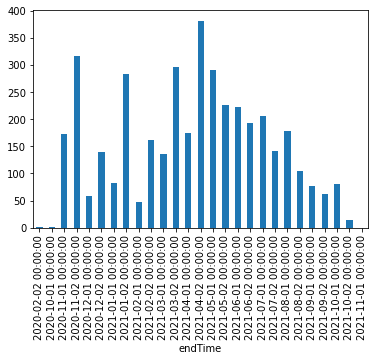

In [34]:
def new_listens(df, granularity="month"):
    df = df.copy()
    df.sort_values(by="endTime", ascending=True)
    df.endTime = df.endTime - pd.offsets.MonthBegin(0)
    df.endTime = df.endTime.dt.round('d')
    
    known = set()
    df["new"] = 0
    
    # Doesn't account for different songs having same name. Solve using track ids
    for idx, track in df[["trackName"]].itertuples():
        if track not in known:
            known.add(track)
            df.at[idx, "new"] = 1
            
    return df.groupby("endTime")["new"].sum()


new_listens(df).plot(kind="bar")
plt.show()